In [3]:
import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import torch
import ast
import gradio as gr
import networkx as nx
from collections import defaultdict
import json
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorForTokenClassification
)
from torch.utils.data import Dataset
import json
from llama_cpp import Llama

In [4]:
# Загрузка данных
dataset = load_dataset('vishnun/NLP-KnowledgeGraph')
df = pd.DataFrame(dataset['train'])

print("Размер датасета:", len(df))
print("Первые 5 строк:")
print(df.head())

Размер датасета: 43594
Первые 5 строк:
                                            sentence     source     target  \
0               a group of soldiers provide security      group   security   
1  this beautiful waves ring is crafted in platin...  beautiful      waves   
2  A plate of salad that includes strawberries on...       that       side   
3  map from which users can select the district i...       they  hospitals   
4      coach is given a guard of honour from players      coach    players   

            relation                                             tokens  \
0        ['provide']  ['a', 'group', 'of', 'soldiers', 'provide', 's...   
1  ['crafted', 'in']  ['this', 'beautiful', 'waves', 'ring', 'is', '...   
2    ['plate', 'of']  ['A', 'plate', 'of', 'salad', 'that', 'include...   
3    ['map', 'from']  ['map', 'from', 'which', 'users', 'can', 'sele...   
4          ['given']  ['coach', 'is', 'given', 'a', 'guard', 'of', '...   

                                         

In [5]:
# Анализ распределения тегов
def parse_tags(tags_str):
    return ast.literal_eval(tags_str)

def parse_tokens(tokens_str):
    return ast.literal_eval(tokens_str)

df['parsed_tags'] = df['tags'].apply(parse_tags)
df['parsed_tokens'] = df['tokens'].apply(parse_tokens)

all_tags = []
for tags in df['parsed_tags']:
    all_tags.extend(tags)

tag_counts = pd.Series(all_tags).value_counts()
print("\nРаспределение тегов:")
print(tag_counts)


Распределение тегов:
O      300008
REL     66261
SRC     61689
TGT     50344
Name: count, dtype: int64



Средняя длина предложения: 10.97
Медианная длина предложения: 11.00


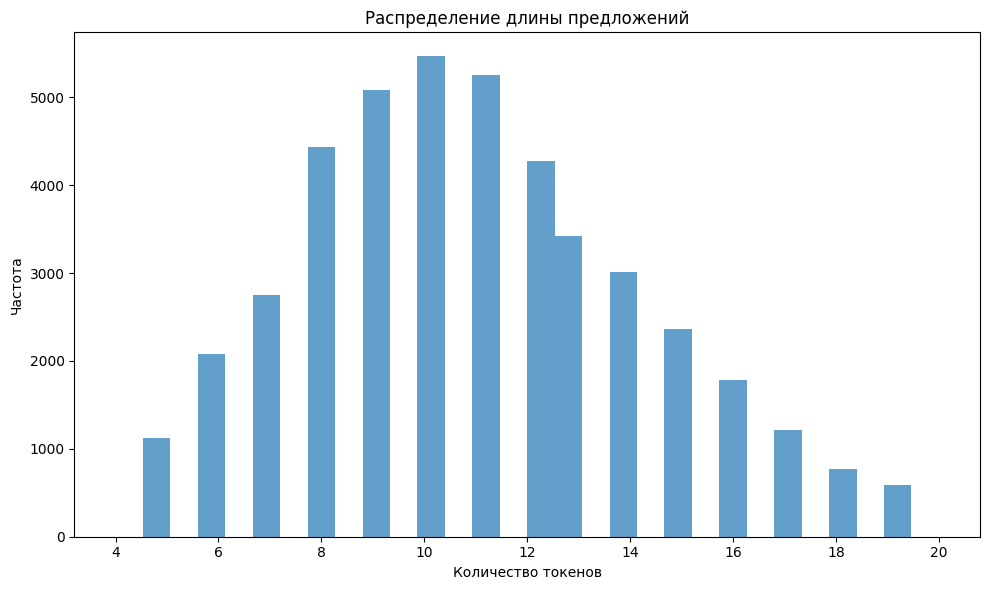

In [4]:
# Визуализация 
plt.figure(figsize=(10, 6))
tag_counts.plot(kind='bar')
plt.title('Распределение тегов в датасете')
plt.xlabel('Теги')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('tag_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# Анализ длины предложений
sentence_lengths = df['parsed_tokens'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=30, alpha=0.7)
plt.title('Распределение длины предложений')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.tight_layout()
plt.savefig('sentence_length_distribution.png', dpi=300, bbox_inches='tight')

print(f"\nСредняя длина предложения: {sentence_lengths.mean():.2f}")
print(f"Медианная длина предложения: {sentence_lengths.median():.2f}")


In [6]:
# Создание графа знаний из данных
def create_knowledge_graph(df):
    G = nx.DiGraph()
    
    for _, row in df.iterrows():
        source = row['source']
        target = row['target']
        relation = ast.literal_eval(row['relation'])[0] if row['relation'] != "[]" else "unknown"
        
        G.add_node(source, type='entity')
        G.add_node(target, type='entity')
        G.add_edge(source, target, relation=relation)
    
    return G

kg = create_knowledge_graph(df)
print(f"\nГраф знаний создан:")
print(f"Количество узлов: {kg.number_of_nodes()}")
print(f"Количество ребер: {kg.number_of_edges()}")

# Анализ наиболее связанных узлов
degree_centrality = nx.degree_centrality(kg)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nТоп-10 наиболее связанных узлов:")
for node, centrality in top_nodes:
    print(f"{node}: {centrality:.4f}")


nx.write_gexf(kg, 'knowledge_graph.gexf')
print("\nГраф знаний сохранен в файл knowledge_graph.gexf")


Граф знаний создан:
Количество узлов: 6449
Количество ребер: 19015

Топ-10 наиболее связанных узлов:
that: 0.0932
man: 0.0662
it: 0.0471
city: 0.0454
i: 0.0431
politician: 0.0431
woman: 0.0391
you: 0.0352
he: 0.0337
they: 0.0327

Граф знаний сохранен в файл knowledge_graph.gexf


In [7]:
# Создание маппинга тегов
unique_tags = set()
for tags in df['parsed_tags']:
    unique_tags.update(tags)

tag2id = {tag: i for i, tag in enumerate(sorted(unique_tags))}
id2tag = {i: tag for tag, i in tag2id.items()}

print("Маппинг тегов:")
print(tag2id)

Маппинг тегов:
{'O': 0, 'REL': 1, 'SRC': 2, 'TGT': 3}


In [49]:
# Подготовка данных для обучения
class NERDataset(Dataset):
    def __init__(self, texts, tags, tokenizer, max_length=128):
        self.texts = texts
        self.tags = tags
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        tags = self.tags[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt',
            is_split_into_words=True
        )
        
        word_ids = encoding.word_ids()
        aligned_labels = []
        
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)
            else:
                if word_id < len(tags):
                    aligned_labels.append(tag2id[tags[word_id]])
                else:
                    aligned_labels.append(-100)
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(aligned_labels, dtype=torch.long)
        }


In [50]:
# Разделение данных
train_texts, test_texts, train_tags, test_tags = train_test_split(
    df['parsed_tokens'].tolist(),
    df['parsed_tags'].tolist(),
    test_size=0.2,
    random_state=42
)

# Инициализация
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)

# Создание датасетов
train_dataset = NERDataset(train_texts, train_tags, tokenizer)
test_dataset = NERDataset(test_texts, test_tags, tokenizer)

# Настройка обучения
training_args = TrainingArguments(
    output_dir="./fast_results",
    per_device_train_batch_size=32,  
    gradient_accumulation_steps=1, 
    num_train_epochs=2,              
    max_steps=500,           
    fp16=True,                      
    bf16=False,                
    optim="adamw_torch_fused",    
    learning_rate=5e-4,
    warmup_steps=50,                 
    lr_scheduler_type="linear",
    eval_strategy="no",       
    save_strategy="no",
    logging_steps=50,
    dataloader_num_workers=8,     
    dataloader_pin_memory=True,
    report_to="none",
    ddp_find_unused_parameters=False,
)

# Коллатор
data_collator = DataCollatorForTokenClassification(tokenizer)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Функция для вычисления метрик
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    
    # Удаляем игнорируемые индексы
    true_predictions = [
        [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    # Вычисляем F1-score
    all_true_labels = []
    all_predictions = []
    for true_label, prediction in zip(true_labels, true_predictions):
        all_true_labels.extend(true_label)
        all_predictions.extend(prediction)
    
    f1 = f1_score(all_true_labels, all_predictions, average='weighted')
    
    return {
        'f1': f1
    }

# Создание тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# Сохранение модели
model.save_pretrained('./ner_model')
tokenizer.save_pretrained('./ner_model')

print("Модель обучена и сохранена!")
results = trainer.evaluate()
print("Результаты оценки:")
print(results)

/home/lad1chka/envnir/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.720900
100,0.459900
150,0.407800
200,0.375800
250,0.370600
300,0.347500
350,0.316200
400,0.282900
450,0.287400
500,0.265500


Модель обучена и сохранена!


Результаты оценки:
{'eval_loss': 0.2546572983264923, 'eval_f1': 0.9116265587973232, 'eval_runtime': 385.4983, 'eval_samples_per_second': 22.617, 'eval_steps_per_second': 2.828, 'epoch': 0.45871559633027525}


Теперь посмотрим на простую NER модель

In [8]:
# Простая модель для демонстрации
class SimpleNERModel:
    def __init__(self):
        self.tag2id = {'O': 0, 'REL': 1, 'SRC': 2, 'TGT': 3}
        self.id2tag = {0: 'O', 1: 'REL', 2: 'SRC', 3: 'TGT'}
        
    def predict(self, tokens):
        # Простая эвристика для демонстрации
        predictions = []
        for token in tokens:
            if token.lower() in ['provide','in','on', 'give','finds', 'offer', 'create', 'make', 'has', 'is', 'are']:
                predictions.append('REL')
            elif token.lower() in ['group','you', 'man', 'woman', 'person', 'people', 'team']:
                predictions.append('SRC')
            elif token.lower() in ['security', 'service', 'help', 'support', 'protection']:
                predictions.append('TGT')
            else:
                predictions.append('O')
        return predictions

In [48]:
model = SimpleNERModel()
all_true_labels = []
all_predictions = []

for tokens, true_tags in zip(test_texts[:1000], test_tags[:1000]):  # Берем первые 1000 для быстроты
    predictions = model.predict(tokens)
    min_len = min(len(predictions), len(true_tags))
    all_true_labels.extend(true_tags[:min_len])
    all_predictions.extend(predictions[:min_len])

f1 = f1_score(all_true_labels, all_predictions, average='weighted')
report = classification_report(all_true_labels, all_predictions)

print(f"F1-score: {f1:.4f}")
print("\nОтчет по классификации:")
print(report)

results = {
    'f1_score': f1,
    'classification_report': report,
    'model_type': 'Simple Rule-based NER',
    'test_samples': 1000
}

print("\nПримеры предсказаний:")
for i in range(5):
    tokens = test_texts[i]
    true_tags = test_tags[i]
    predictions = model.predict(tokens)
    
    print(f"\nПример {i+1}:")
    print(f"Токены: {tokens}")
    print(f"Истинные теги: {true_tags}")
    print(f"Предсказанные теги: {predictions}")

F1-score: 0.5144

Отчет по классификации:
              precision    recall  f1-score   support

           O       0.64      0.93      0.76      6937
         REL       0.31      0.14      0.20      1515
         SRC       0.54      0.05      0.09      1411
         TGT       0.15      0.00      0.00      1154

    accuracy                           0.61     11017
   macro avg       0.41      0.28      0.26     11017
weighted avg       0.53      0.61      0.51     11017


Примеры предсказаний:

Пример 1:
Токены: ['an', 'early', 'morning', 'in', 'august', 'finds', 'the', 'author', 'on', 'his', 'dock', 'officially', 'known', '.']
Истинные теги: ['O', 'O', 'O', 'REL', 'O', 'REL', 'O', 'SRC', 'O', 'O', 'TGT', 'O', 'O', 'O']
Предсказанные теги: ['O', 'O', 'O', 'REL', 'O', 'REL', 'O', 'O', 'REL', 'O', 'O', 'O', 'O', 'O']

Пример 2:
Токены: ['A', 'man', 'operates', 'a', 'machine', 'that', 'produces', 'nails', 'or', 'screws.']
Истинные теги: ['O', 'O', 'REL', 'SRC', 'O', 'SRC', 'O', 'TGT', 'O

Теперь посмотрим на GraphRAG

In [10]:
llm = Llama(model_path="/home/lad1chka/IMPORTS/mistral-7b-instruct-v0.1.Q4_K_M.gguf", n_ctx=2048, verbose=False)

llama_context: n_ctx_per_seq (2048) < n_ctx_train (32768) -- the full capacity of the model will not be utilized


In [13]:
class GraphRAG:
    def __init__(self, knowledge_graph_path=None):
        if knowledge_graph_path:
            self.kg = nx.read_gexf(knowledge_graph_path)
        else:
            self.kg = nx.DiGraph()
        
    def add_triple(self, source, relation, target):
        # Добавляет тройку (source, relation, target) в граф знаний 
        self.kg.add_node(source, type='entity')
        self.kg.add_node(target, type='entity')
        self.kg.add_edge(source, target, relation=relation)
    
    def search_related_entities(self, entity, max_depth=2):
        # Поиск связанных сущностей в графе знаний         
        if entity not in self.kg:
            return []
        
        related = []
        
        # Прямые связи
        for neighbor in self.kg.neighbors(entity):
            edge_data = self.kg.get_edge_data(entity, neighbor)
            relation = edge_data.get('relation', 'unknown')
            related.append({
                'entity': neighbor,
                'relation': relation,
                'distance': 1
            })
        
        # Обратные связи
        for predecessor in self.kg.predecessors(entity):
            edge_data = self.kg.get_edge_data(predecessor, entity)
            relation = edge_data.get('relation', 'unknown')
            related.append({
                'entity': predecessor,
                'relation': f"inverse_{relation}",
                'distance': 1
            })
        
        return related
    
    def answer_question(self, question, context_entities=None, max_relations=10):
        if context_entities is None:
            context_entities = []
            
        relevant_info = []
        for entity in context_entities:
            related = self.search_related_entities(entity)
            relevant_info.extend(related)
        context = "Контекст из графа знаний:\n"
        unique_relations = set()
        for info in relevant_info[:max_relations]:
            relation_str = f"{info['entity']} -> {info['relation']} -> {info['distance']}"
            if relation_str not in unique_relations:
                context += f"- {relation_str}\n"
                unique_relations.add(relation_str)
        print(context)
        prompt = f"""You are an intelligent assistant that answers questions using the provided knowledge graph context.

        Knowledge Graph Context:
        {context}

        Question: {question}

        Answer:"""
        
        try:
            response = llm.create_chat_completion(
                    messages=[{"role": "user", "content": prompt}]
                )
            answer = response["choices"][0]["message"]["content"].strip().lower()
        except Exception as e:
            answer = f"Ошибка при генерации ответа: {str(e)}"
        return {
            'answer': answer,
            'context': context,
            'related_entities': relevant_info[:max_relations]
        }

In [14]:
# Создание GraphRAG системы
def create_graphrag_system():
    dataset = load_dataset('vishnun/NLP-KnowledgeGraph')
    df = pd.DataFrame(dataset['train'])
    
    graph_rag = GraphRAG()
    
    # Заполнение графа знаний из данных
    for _, row in df.iterrows():
        source = row['source']
        target = row['target']
        relation_str = row['relation']
        
        try:
            relations = ast.literal_eval(relation_str)
            if relations:
                relation = relations[0]
            else:
                relation = 'unknown'
        except:
            relation = 'unknown'
        
        graph_rag.add_triple(source, relation, target)
    
    return graph_rag

# Создание системы
print("Создание GraphRAG системы...")
graph_rag = create_graphrag_system()

print(f"Граф знаний содержит {graph_rag.kg.number_of_nodes()} узлов и {graph_rag.kg.number_of_edges()} ребер")

# Тестирование системы
test_questions = [
    {
        'question': 'What does a group of soldiers provide?',
        'entities': ['group', 'soldiers']
    },
    {
        'question': 'Who creates beautiful waves?',
        'entities': ['beautiful', 'waves']
    },
    {
        'question': 'What does a salad plate include?',
        'entities': ['plate', 'salad']
    }
]

print("\nТестирование GraphRAG системы:")
results = []

for i, test in enumerate(test_questions):
    print(f"\n--- Тест {i+1} ---")
    result = graph_rag.answer_question(test['question'], test['entities'])
    
    print(f"Вопрос: {test['question']}")
    print(f"Ответ: {result['answer']}")
    print(f"Найдено связанных сущностей: {len(result['related_entities'])}")
    
    results.append({
        'question': test['question'],
        'entities': test['entities'],
        'answer': result['answer'],
        'related_entities_count': len(result['related_entities']),
        'context': result['context']
    })


print("\nАнализ производительности GraphRAG:")
print(f"Средняя длина контекста: {sum(len(r['context']) for r in results) / len(results):.0f} символов")
print(f"Среднее количество связанных сущностей: {sum(r['related_entities_count'] for r in results) / len(results):.1f}")

nx.write_gexf(graph_rag.kg, 'final_knowledge_graph.gexf')
print("Финальный граф знаний сохранен в final_knowledge_graph.gexf")

Создание GraphRAG системы...
Граф знаний содержит 6449 узлов и 19015 ребер

Тестирование GraphRAG системы:

--- Тест 1 ---
Контекст из графа знаний:
- security -> provide -> 1
- luggage -> turns -> 1
- country -> playing -> 1
- next -> standing -> 1
- trees -> feed -> 1
- together -> dance -> 1
- football -> practicing -> 1
- young -> play -> 1
- dance -> are -> 1
- salt -> await -> 1

Вопрос: What does a group of soldiers provide?
Ответ: a group of soldiers provide security.
Найдено связанных сущностей: 10

--- Тест 2 ---
Контекст из графа знаний:
- waves -> crafted -> 1
- time -> reflected -> 1
- tier -> rotated -> 1
- green -> grows -> 1
- mountain -> rests -> 1
- gold -> draped -> 1
- canopy -> bathed -> 1
- dark -> walking -> 1
- birds -> view -> 1
- place -> inverse_surrounded -> 1

Вопрос: Who creates beautiful waves?
Ответ: the answer is not provided in the given knowledge graph context.
Найдено связанных сущностей: 10

--- Тест 3 ---
Контекст из графа знаний:
- it -> arranged 

Реализация Gradio app

In [51]:
class GraphRAGDemo:
    def __init__(self):
        self.kg = None
        self.load_knowledge_graph()
    
    def load_knowledge_graph(self):
        try:
            self.kg = nx.read_gexf('final_knowledge_graph.gexf')
        except:
            print("Создание нового графа знаний...")
            dataset = load_dataset('vishnun/NLP-KnowledgeGraph')
            df = pd.DataFrame(dataset['train'])
            self.kg = nx.DiGraph()
            for _, row in df.iterrows():
                source = row['entity']
                target = row['distance']
                relation_str = row['relation']
                
                try:
                    relations = ast.literal_eval(relation_str)
                    if relations:
                        relation = relations[0]
                    else:
                        relation = 'unknown'
                except:
                    relation = 'unknown'
                self.kg.add_node(source, type='entity')
                self.kg.add_node(target, type='entity')
                self.kg.add_edge(source, target, relation=relation)
    
    def extract_entities(self, text):
        # Простая эвристика для демонстрации
        words = text.lower().split()
        entities = []
        # Ищем слова, которые есть в графе знаний
        for word in words:
            if word in self.kg.nodes():
                entities.append(word)
        return entities
    
    def search_related_entities(self, entity, max_depth=2):
        # Поиск связанных сущностей         
        if entity not in self.kg:
            return []
        
        related = []
        
        # Прямые связи
        for neighbor in self.kg.neighbors(entity):
            edge_data = self.kg.get_edge_data(entity, neighbor)
            relation = edge_data.get('relation', 'unknown')
            related.append({
                'entity': neighbor,
                'relation': relation,
                'type': 'outgoing'
            })
        
        # Обратные связи
        for predecessor in self.kg.predecessors(entity):
            edge_data = self.kg.get_edge_data(predecessor, entity)
            relation = edge_data.get('relation', 'unknown')
            related.append({
                'entity': predecessor,
                'relation': relation,
                'type': 'incoming'
            })
        
        return related
        
    def answer_question(self, question, max_relations=10):
        context_entities = test['entities']
        relevant_info = []
        for entity in context_entities:
            related = self.search_related_entities(entity)
            relevant_info.extend(related)
        context = "Контекст из графа знаний:\n"
        unique_relations = set()
        for info in relevant_info[:max_relations]:
            relation_str = f"{info['entity']} -> {info['relation']} -> {info['type']}"
            if relation_str not in unique_relations:
                context += f"- {relation_str}\n"
                unique_relations.add(relation_str)
        prompt = f"""You are an intelligent assistant that answers questions using the provided knowledge graph context.

        Knowledge Graph Context:
        {context}

        Question: {question}

        Answer:"""
        
        try:
            response = llm.create_chat_completion(
                    messages=[{"role": "user", "content": prompt}]
                )
            answer = response["choices"][0]["message"]["content"].strip().lower()
        except Exception as e:
            answer = f"Ошибка при генерации ответа: {str(e)}"
        return answer,context,relevant_info[:max_relations]

In [52]:
demo_system = GraphRAGDemo()

In [55]:
def process_question(question):
    if not question.strip():
        return "Пожалуйста, введите вопрос.", "", "Сущности не найдены"
    
    answer, context, entities = demo_system.answer_question(question)
    entities_str = f"Найденные сущности: {entities}" if entities else "Сущности не найдены"
    
    return answer, context, entities_str

def get_graph_stats():
    if demo_system.kg:
        nodes = demo_system.kg.number_of_nodes()
        edges = demo_system.kg.number_of_edges()
        return f"Граф содержит {nodes} узлов и {edges} ребер"
    return "Граф не загружен"


In [56]:
# интерфейс
with gr.Blocks(title="GraphRAG Demo", theme=gr.themes.Soft()) as demo:
    gr.Markdown("# GraphRAG Демонстрация")
    gr.Markdown("Эта демонстрация показывает работу системы GraphRAG для ответов на вопросы с использованием графа знаний.")
    
    with gr.Row():
        with gr.Column():
            gr.Markdown("## Статистика графа знаний")
            stats_output = gr.Textbox(
                value=get_graph_stats(),
                label="Информация о графе",
                interactive=False
            )
    
    with gr.Row():
        with gr.Column():
            question_input = gr.Textbox(
                label="Введите ваш вопрос",
                placeholder="Например: Что предоставляет группа?",
                lines=2
            )
            submit_btn = gr.Button("Получить ответ", variant="primary")
    
    with gr.Row():
        with gr.Column():
            answer_output = gr.Textbox(
                label="Ответ",
                lines=3,
                interactive=False
            )
            context_output = gr.Textbox(
                label="Контекст из графа знаний",
                lines=5,
                interactive=False
            )
            entities_output = gr.Textbox(
                label="Извлеченные сущности",
                lines=1,
                interactive=False
            )
    
    gr.Markdown("## Примеры вопросов:")
    example_questions = [
        "What does a group of soldiers provide?",
        "Who creates beautiful waves?",
        "What does a salad plate include?"
    ]
    
    examples = gr.Examples(
        examples=[[q] for q in example_questions],
        inputs=[question_input],
        outputs=[answer_output, context_output, entities_output],
        fn=process_question,
        cache_examples=False
    )
    
    # Обработка событий
    submit_btn.click(
        fn=process_question,
        inputs=[question_input],
        outputs=[answer_output, context_output, entities_output]
    )
    
    question_input.submit(
        fn=process_question,
        inputs=[question_input],
        outputs=[answer_output, context_output, entities_output]
    )

print("Запуск GraphRAG демонстрации...")
demo.launch()

Запуск GraphRAG демонстрации...
* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


Контекст из графа знаний:
- it -> arranged -> outgoing
- sweet -> filled -> outgoing
- skewed -> contains -> outgoing
- meat -> contains -> outgoing
- many -> contains -> outgoing
- several -> has -> outgoing
- three -> has -> outgoing
- cooked -> contains -> outgoing
- kind -> contains -> outgoing
- thin -> holds -> outgoing

Контекст из графа знаний:
- it -> arranged -> outgoing
- sweet -> filled -> outgoing
- skewed -> contains -> outgoing
- meat -> contains -> outgoing
- many -> contains -> outgoing
- several -> has -> outgoing
- three -> has -> outgoing
- cooked -> contains -> outgoing
- kind -> contains -> outgoing
- thin -> holds -> outgoing

Контекст из графа знаний:
- it -> arranged -> outgoing
- sweet -> filled -> outgoing
- skewed -> contains -> outgoing
- meat -> contains -> outgoing
- many -> contains -> outgoing
- several -> has -> outgoing
- three -> has -> outgoing
- cooked -> contains -> outgoing
- kind -> contains -> outgoing
- thin -> holds -> outgoing

